# Выявление закономерностей успешности игры

Заказчик интернет-магазин "Стримчик", который продаёт по всему миру компьютерные видеоигры.  
Доступны исторические данные о продаже игр, оценки пользователей и экспертов, жанры и платформы. Нужно выявить закономерности успешности игр, что позволит сделать ставку на потенциально популярный продукт и спланировать рекламные компании.

## Откроем файл с данными и изучим общую информацию

In [1]:
# импортируем библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from scipy import stats as st

In [2]:
# считываем файл с данными
try:
    df_games = pd.read_csv('games.csv', sep=',')
except:
    df_games = pd.read_csv('/datasets/games.csv', sep=',')

In [3]:
# смотрим общую информацию по датафрейму
display(df_games.info())
df_games.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [4]:
# проверили дубликаты
df_games.duplicated().sum()

0

In [5]:
# смотрю значения, которые встречаются в рейтинге ESRB в столбце
df_games['Rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

### Краткий вывод общей информации

Датафрейм содержит 11 столбцов. Всего 16715 записей.  
На первый взгляд столбцы приведём далее к нижнему регистру.   
Порядка половины игр имеют оценку критиков и пользователей.  
Столбец `User_Score` тип объект, хотя должен содержать оценки пользователей, посмотрим из-за чего он получился объектным.  
Посмотреть значения столбца, что означают буквенные обозначения `Rating` можно в [Википендия](https://ru.wikipedia.org/wiki/Entertainment_Software_Rating_Board)     
Дубликатов в таблице нет.

## Подготовим данные

### Заменяем  названия столбцов (приводим в нижнему регистру)

In [6]:
# приведём названия столбцов к нижнему регистру
# создаем пустой словарь
# берём каждый столбец в датафрейме и если он содержит прописные буквы, то мы присваиваем ключу 
# старого значения значение столбца в нижнем регистре.
set_column = {}
for column in df_games.columns:
    if ~column.islower():
        set_column[column] = column.lower()
# переименовываем столбцы из set_column в датафрейме
df_games = df_games.rename(columns=set_column)         

### Преобразуем данные в нужные типы

In [7]:
# выборочно смотрю структуру даты в типе object
display(df_games['year_of_release'].sample(5))
print(df_games['year_of_release'].min(), df_games['year_of_release'].max())
# проверяю количество записей без даты
df_games['year_of_release'].isna().sum()

10475    2012.0
10327    2000.0
8072     2013.0
10486       NaN
12789    2013.0
Name: year_of_release, dtype: float64

1980.0 2016.0


269

Всего получаем 269 записей без даты релиза игры. Мы можем эти записи безболезненно удалить, так как без даты они не играют для нас роли и их мало в отношении остального датафрейма. Даты релиза от 1980 года до 2016 года.  
Также приведём дату к целочисленному типу.

In [8]:
# удалим строки без даты релиза и проверим корректность удаления
df_games = df_games.dropna(subset=['year_of_release'])
df_games['year_of_release'].isna().sum()

0

In [9]:
# преобразуем столбец с годом релиза в целочисленный тип
df_games['year_of_release'] = df_games['year_of_release'].astype('int16')

### Обрабатываю пропуски

In [10]:
# смотрю значения в столбце оценок пользователей
df_games['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [11]:
# смотрю с чем связано значение 'tbd'
df_games.query('user_score == "tbd"').head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
119,Zumba Fitness,Wii,2010,Sports,3.45,2.59,0.0,0.66,NaN,tbd,E
301,Namco Museum: 50th Anniversary,PS2,2005,Misc,2.08,1.35,0.0,0.54,61.0,tbd,E10+
520,Zumba Fitness 2,Wii,2011,Sports,1.51,1.03,0.0,0.27,NaN,tbd,T
645,uDraw Studio,Wii,2010,Misc,1.65,0.57,0.0,0.20,71.0,tbd,E
718,Just Dance Kids,Wii,2010,Misc,1.52,0.54,0.0,0.18,NaN,tbd,E


Значения 'tbd' представляют собой аббревиатуру в общеупотребляемом плане, как 'to be defined' (предстоит определить, будет определено). Получается нет данных по сумарным оценкам пользователей по этим записям и это тоже самое, что нет данных, значения не определено.

In [12]:
# заменим значения 'tbd' предстоит определить - на пропуски
# приведем значения рейтинга к типу float
# параметр errors='coerce' обработает значения 'tbd' и приведет их к nan
df_games['user_score'] = df_games['user_score'].apply(pd.to_numeric, errors='coerce')

По пропущенным значениям в столбцах рейтингов мы пропуски заполнять не будем, так как будет неверно заполнить их каким-либо значением, в любом случае это будет искажение данных для последующих исследований.

In [13]:
# смотрю данные по пропускам в столбце названия игры
df_games[df_games['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Два пропуска в наименовании игры и его жанре можем удалить, так как наличие их не будет нести никакой информации для выявления наших закономерностей, так отсутствуют все данные, за которые можно зацепиться.

In [14]:
# удаляем два пропуска в имени и жанре
df_games = df_games.dropna(subset=['name'])

По столбцу `rating` заполним пропущенные значения значением *нет данных*, так как данные по этим играм отсутствуют.

In [15]:
# заполняем пропущенные значения значением 'нет данных' в столбце rating
df_games.loc[df_games['rating'].isna(), 'rating'] = 'нет данных'

### Посчитаем суммарные продажи во всех регионах и запишем в отдельный столбец

In [16]:
# считаем в столбец 'total_sales' все продажи по регионам для каждой игры
df_games['total_sales'] = (df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales']
                        + df_games['other_sales'])

## Проведём исследовательский анализа данных

### Сколько игр выпускалось в разные годы.

In [17]:
# установим стиль для вывода графиков
sns.set_style('darkgrid',
              {'axes.facecolor': '0.9',
               'grid.color': '0.1',
               'figure.facecolor': '0.85'})

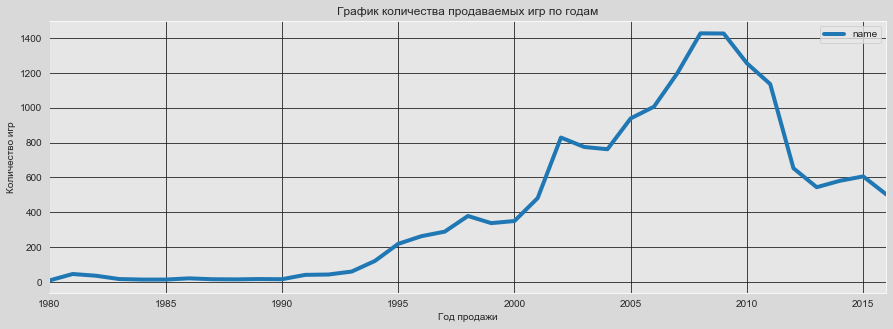

In [18]:
# сделаем группировку по годам и количеству игр, построим график
df_games.groupby('year_of_release')['name'].agg({'name' : 'count'}).plot(figsize=(15,5), grid=True, linewidth = 4)
plt.title('График количества продаваемых игр по годам')
plt.xlabel('Год продажи')
plt.ylabel("Количество игр");

На графике мы видим, что до 1990 года продавалось несколько десятков игр, к 2000м годам достигнув 400 игр по продажам, далее увеличивая продажи, максимальный уровень продаж 2008-2009 годах. С 2009 года идёт уменьшение продаж.  
Первоначально можно отсечь данные по продажам менее 600 игр в годах, как совсем не релевантные для наших исследований, если взять за равнение 2015 год. Далее мы выделим точнее период.

### Изменение продаж по платформам. Топ платформ по продажам. Срок жизни платформ.

In [19]:
# создаю копию датафрейма для работы с платформами
df = df_games.copy()

In [20]:
# выбираем топ 10 платформ по продажам
platform_sales = (df.groupby('platform').agg({'total_sales' : sum}).
                  sort_values(by='total_sales').tail(10).index)

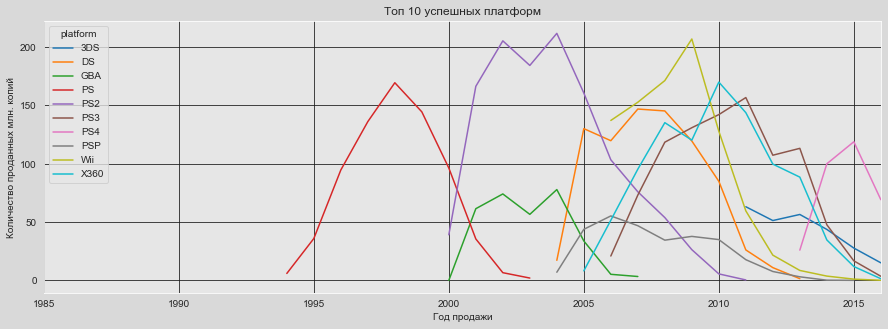

In [21]:
# построим график продаж топ 10 платформ по годам в млн. копий
(df.query('platform in @platform_sales').
     pivot_table(index='year_of_release', columns='platform', values='total_sales', aggfunc='sum').
     plot(figsize=(15,5), grid=True))
plt.title('Топ 10 успешных платформ')
plt.xlabel('Год продажи')
plt.ylabel("Количество проданных млн. копий");

По графику видим, что самая успешная платформа была PS2 с самыми большими продажами и долгим периодом реализации. Вместе с тем, все платформы характерны конечным периодом подъема и далее периодом угасания продаж и после вымиранием. У каждой платформы есть конечный срок успешно реализации игр.  
Посчитаем в среднем какой срок жизни платформ по успешной реализации.  


In [22]:
# группируем данные продаж по платформе и годам реализации, а после выделяем данные по продажам более
# 0,9 млн проданных копий (0,9 млн выбрали исходя из субъективной оценки количества релевантных продаж в год
# для нашего исследования)
actual_period = (df.groupby(['platform','year_of_release']).agg({'total_sales': 'sum'}).
                query('total_sales > 0.9').reset_index())

In [23]:
# расчитает жизненный период каждой платформы и посчитает среднее жизни
actual_period = actual_period.groupby('platform').agg({'year_of_release' : 'count'}).mean()
print(f'В среднем срок жизни платформ для игр равен: {actual_period["year_of_release"]} лет')

В среднем срок жизни платформ для игр равен: 8.0 лет


### Выбираем данные за актуальный период

Исходя из предыдущих исследований мы выяснили, что в среднем срок жизни платформы составляет 8 лет.  
Построим столбчатую диаграмму за этот период по продажам и посмотрим на тенденцию.

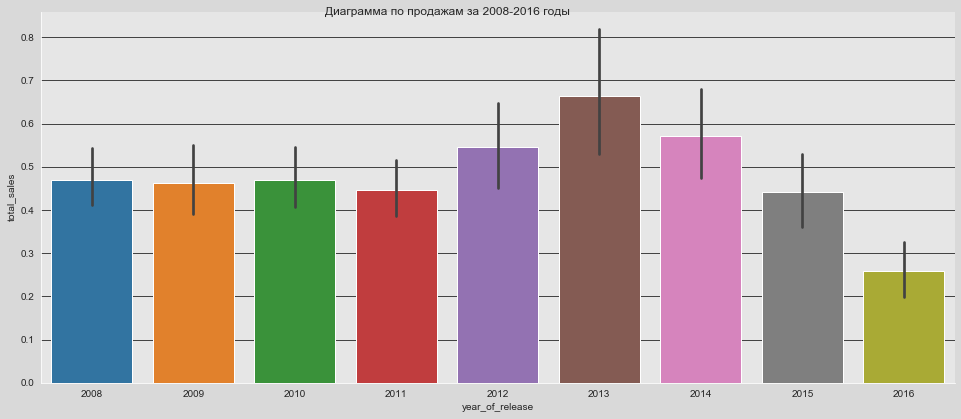

In [24]:
# диаграмма по количеству продаж за 2008-2016 годы
g = (sns.catplot(data=df.query('2008<=year_of_release<=2016'), 
                 x="year_of_release", y="total_sales", kind='bar'));
# указываем заголовок столбцовой диаграммы
g.fig.set_size_inches(15,6)
g.fig.suptitle(f'Диаграмма по продажам за 2008-2016 годы');

Мы можем взять 2014, как начало стабилизирующего периода продаж, после росла за несколько предыдущих лет. В 2016 году данные не полные по продажам, поэтому количество меньше.  
В нашем случае актуальный период для исследований, по которым мы можем прогнозировать успешность игр на 2017 год, будет 2014-2016 годы.

In [25]:
# Отфильтруем данные по 2014-2016 годам.
df= df.loc[df['year_of_release'] >= 2014].reset_index(drop=True)

In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1689 entries, 0 to 1688
Data columns (total 12 columns):
name               1689 non-null object
platform           1689 non-null object
year_of_release    1689 non-null int16
genre              1689 non-null object
na_sales           1689 non-null float64
eu_sales           1689 non-null float64
jp_sales           1689 non-null float64
other_sales        1689 non-null float64
critic_score       718 non-null float64
user_score         888 non-null float64
rating             1689 non-null object
total_sales        1689 non-null float64
dtypes: float64(7), int16(1), object(4)
memory usage: 148.6+ KB


### Выбираем несколько потенциально прибыльных платформ

In [27]:
# смотрим сводные данные по платформам за 2014-2016 годы
df.pivot_table(index='year_of_release', columns='platform', \
               values='total_sales', aggfunc='sum').loc[[2014, 2015, 2016]]

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


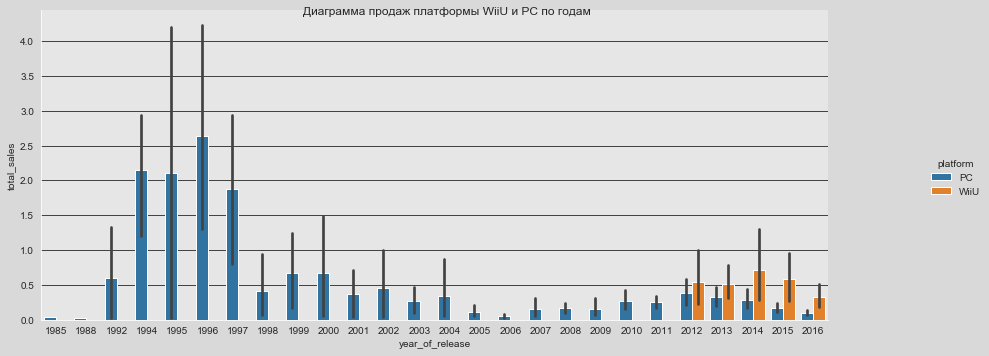

In [28]:
# смотрим продажи по годам платформы WiiU и PC по годам
g = (sns.catplot(data=df_games.query('platform in ("WiiU", "PC") '), 
                 x="year_of_release", y="total_sales", kind='bar', hue='platform'))
g.fig.set_size_inches(15,5)
# указываем заголовок диаграммы
g.fig.suptitle(f'Диаграмма продаж платформы WiiU и PC по годам');

По сводным данным, я вижу, что самая прибыльная платформа с большим отрывом `PS4`, также сильная`XOne` - это две платформы новые поколения своих прешественников.  
Также хорошие результаты у `3DS`, её мы тоже включим в исследования.  
Посмотрел ещё диаграммы продаж по платформам `PC` и `WiiU`. `PC` - будет в топах вне времени. Компьютер апгрейдить не сложно и всегда будет много пользователей, предпочитающие игры на `PC`.  
`WiiU` - это следующее поколение консоли Nintendo, которое тоже в топе и потенциально перспективно.
Эти платформы мы выберем, как потенциально прибыльные для дальнейших исследований.

In [29]:
# топ потенциально прибыльных платформ
top_platform = ['PS4','XOne', '3DS', 'PC', 'WiiU']

### Построим диаграмму размаха по глобальным продажам в разбивке по платформам

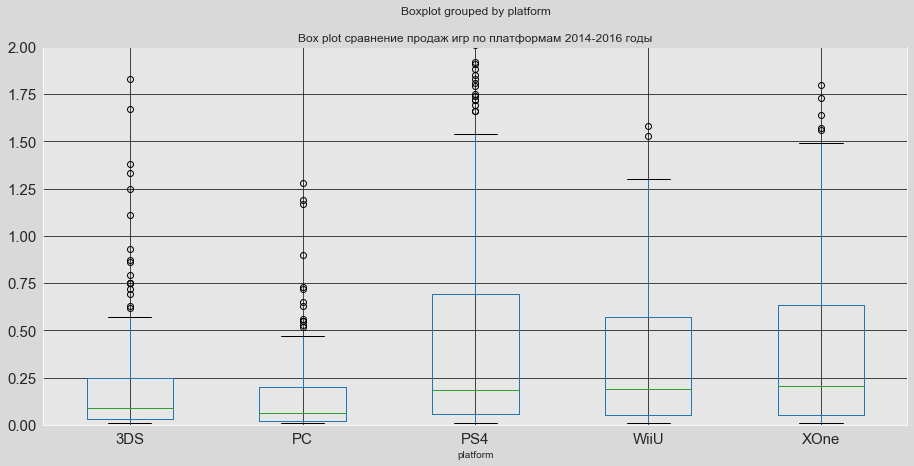

In [30]:
(df.query('platform in @top_platform').boxplot(by='platform', 
                                    column='total_sales', figsize=(15,7), fontsize=15))
# значения по оси y от и до
plt.ylim(0,2)
plt.title('Box plot сравнение продаж игр по платформам 2014-2016 годы');

По диаграмме размаха топ игр за 2014-2016 мы видим, что лучшие медианные продажи на `XOne`,`WiiU` и `PS4`, здесь самые лучшие продажи в среднем по играм. `PS4` имеет самый большой размах, что говорит о больших количествах хитов.  
В целом это три топовых платформы по мировым продажам игр, они намного опережают `3DS` и `PC`.

### Влияние на продажи отзывов пользователей и критиков внутри одной платформы

In [31]:
# функция, считающая выбросы по столбцу в датафрейме
def box_plot_values(df, column):
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
# iqr межквартильный размах
    iqr = q3 - q1 
# границы интервала наиболее вероятных значений min и max
    min_value = q1 - 1.5 * iqr, 
    max_value = q3 + 1.5 * iqr
# считаем количество значений выходящих за границы нормального распредления
    rare_min_value = df.query(f'{column} < @min_value')[column].count()
    rare_max_value = df.query(f'{column} > @max_value')[column].count()
    return print('Столбец', column, '\n' 
                'Первый квартиль = ', q1,'\n' 'Третий квартиль = ', q3,'\n' 'Нижняя граница = ', min_value, '\n' 
                'Верхняя граница = ', max_value, '\n' 'Редкие значения до нижней границы = ', rare_min_value, '\n'
                'Редкие значения выше верхней границы = ', rare_max_value, '\n')

In [32]:
# смотрим результаты по выбросам в столбцах с отзывами и общей продажей игр
box_plot_values(df, 'user_score')
box_plot_values(df, 'critic_score')

Столбец user_score 
Первый квартиль =  5.8 
Третий квартиль =  7.8 
Нижняя граница =  (2.8,) 
Верхняя граница =  10.8 
Редкие значения до нижней границы =  19 
Редкие значения выше верхней границы =  0 

Столбец critic_score 
Первый квартиль =  66.0 
Третий квартиль =  81.0 
Нижняя граница =  (43.5,) 
Верхняя граница =  103.5 
Редкие значения до нижней границы =  21 
Редкие значения выше верхней границы =  0 



In [33]:
# удалим строки с выбросами в общих продажах, отзывах пользователей и критиков
# а также все пустые значения в рейтинге пользователей и критиков
df = df.query('~(critic_score < 43.5) & ~(user_score < 2.80)')

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1655 entries, 0 to 1688
Data columns (total 12 columns):
name               1655 non-null object
platform           1655 non-null object
year_of_release    1655 non-null int16
genre              1655 non-null object
na_sales           1655 non-null float64
eu_sales           1655 non-null float64
jp_sales           1655 non-null float64
other_sales        1655 non-null float64
critic_score       694 non-null float64
user_score         855 non-null float64
rating             1655 non-null object
total_sales        1655 non-null float64
dtypes: float64(7), int16(1), object(4)
memory usage: 158.4+ KB


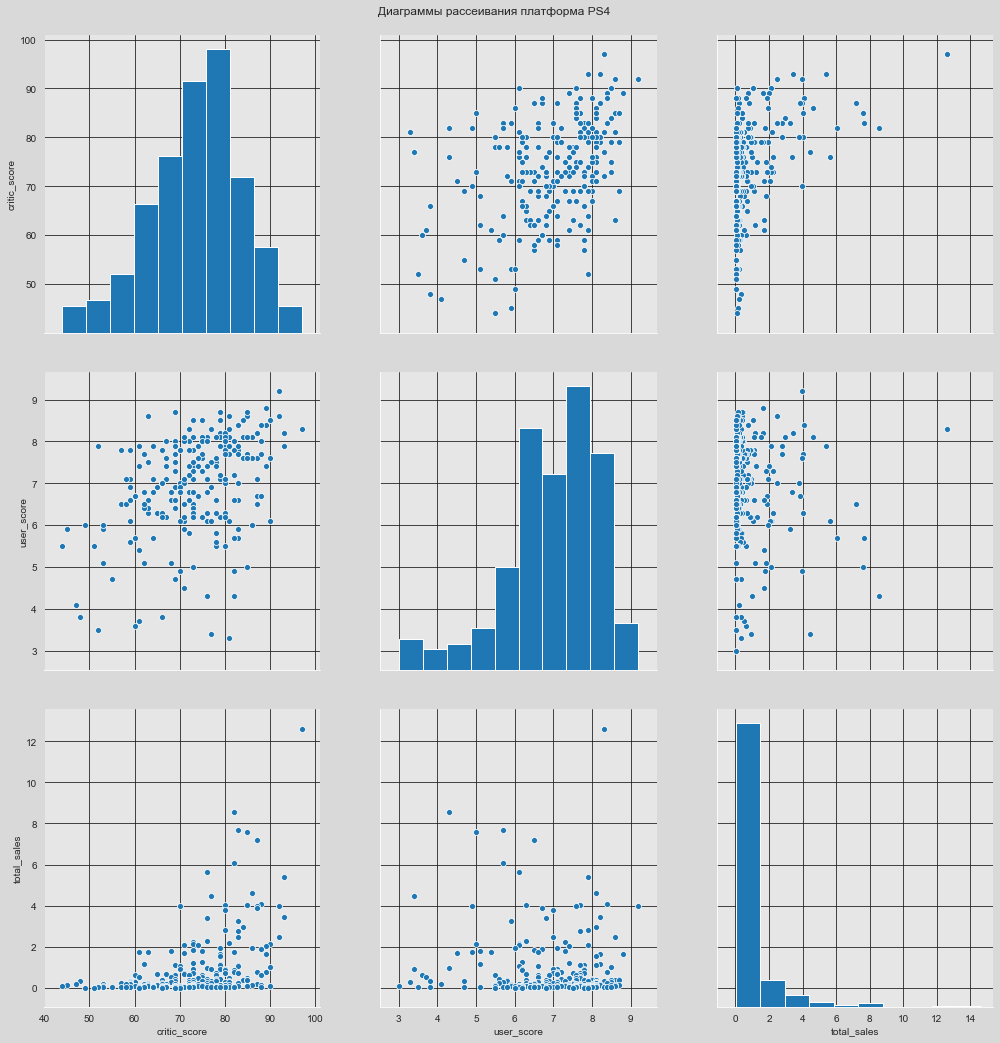

In [35]:
# выбираем платформу для исследования зависимости продаж от отзывов критиков и пользователей
platform_first = 'PS4'
# строим матрицу рассеивания между продажей и отзывами критиков и пользователей (PS4)
g = sns.pairplot(df.query('platform == @platform_first')[['critic_score', 'user_score', 'total_sales']])
# указываем размеры графиков
g.fig.set_size_inches(15,15)
# указываем заголовок диаграмм рассеивания
g.fig.suptitle(f'Диаграммы рассеивания платформа {platform_first}', y=1);

In [36]:
# корреляция между отзывами критиков, пользователей и продажами общими (PS4)
print(f'Таблица корреляции отзывов и продаж по платформе {platform_first}')
df.query('platform == @platform_first')[['critic_score', 'user_score', 'total_sales']].corr()

Таблица корреляции отзывов и продаж по платформе PS4


,critic_score,user_score,total_sales
critic_score,1.000000,0.403325,0.430578
user_score,0.403325,1.000000,-0.096665
total_sales,0.430578,-0.096665,1.000000


По корреляции у нас средняя корреляция между отзывами критиков и общими продажами игр на платформе и нет совсем никакой связи по продажам и отзывами пользователей. Но надо учитывать, что мы видим только линейную корреляцию.     
Между отзывами критиков и пользователей существует средняя связь.  
Самая популярные оценки критиков находятся между 70 и 80, пользовательские оценки по играм на платформе явно лидирует оценка от 7.5 до 8, что говорит о большой удовлетворенности пользователей.

### Построим корреляцию и диаграмму рассеивания по другим топ платформам

Таблица корреляции отзывов и продаж по платформе XOne


,critic_score,user_score,total_sales
critic_score,1.000000,0.336934,0.445910
user_score,0.336934,1.000000,-0.123405
total_sales,0.445910,-0.123405,1.000000


Таблица корреляции отзывов и продаж по платформе 3DS


,critic_score,user_score,total_sales
critic_score,1.000000,0.804715,0.302305
user_score,0.804715,1.000000,0.223056
total_sales,0.302305,0.223056,1.000000


Таблица корреляции отзывов и продаж по платформе PC


,critic_score,user_score,total_sales
critic_score,1.000000,0.389686,0.160394
user_score,0.389686,1.000000,-0.127061
total_sales,0.160394,-0.127061,1.000000


Таблица корреляции отзывов и продаж по платформе WiiU


,critic_score,user_score,total_sales
critic_score,1.000000,0.722120,0.379149
user_score,0.722120,1.000000,0.415622
total_sales,0.379149,0.415622,1.000000


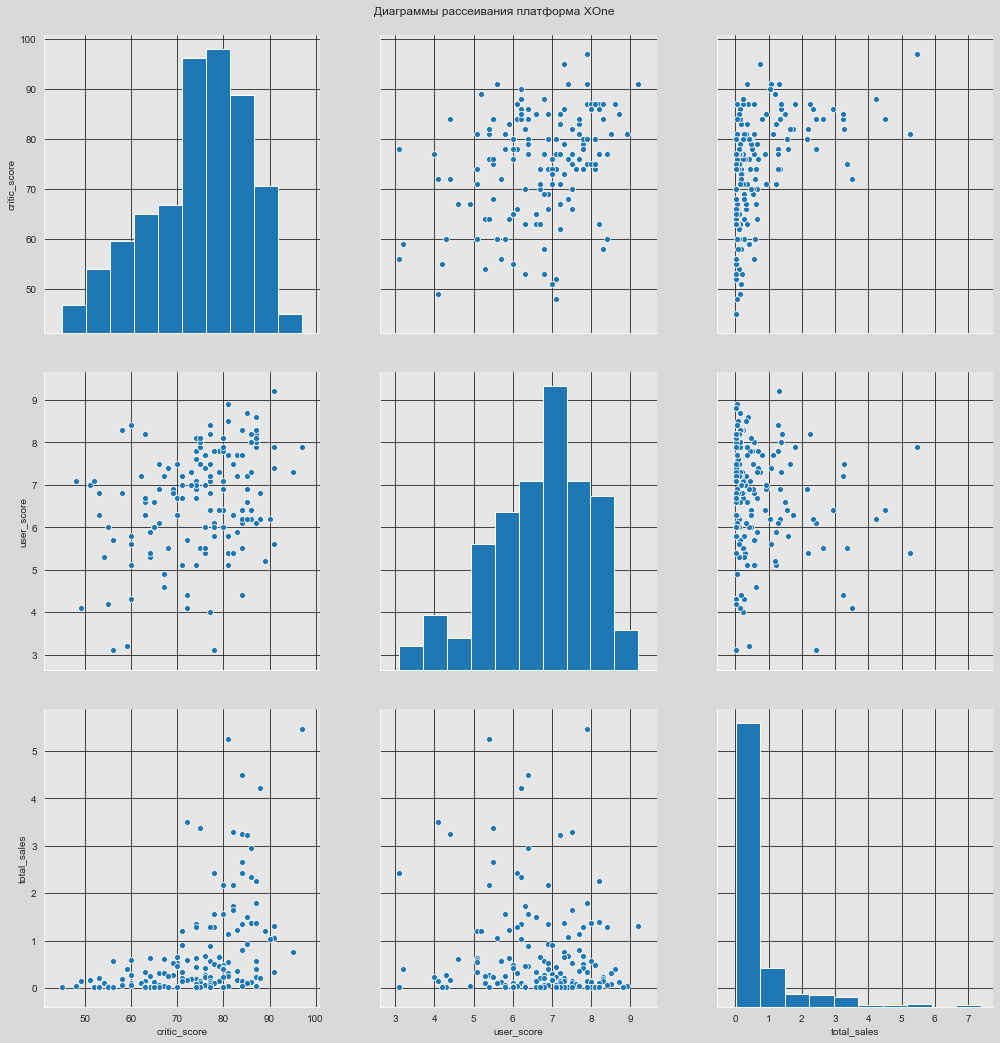

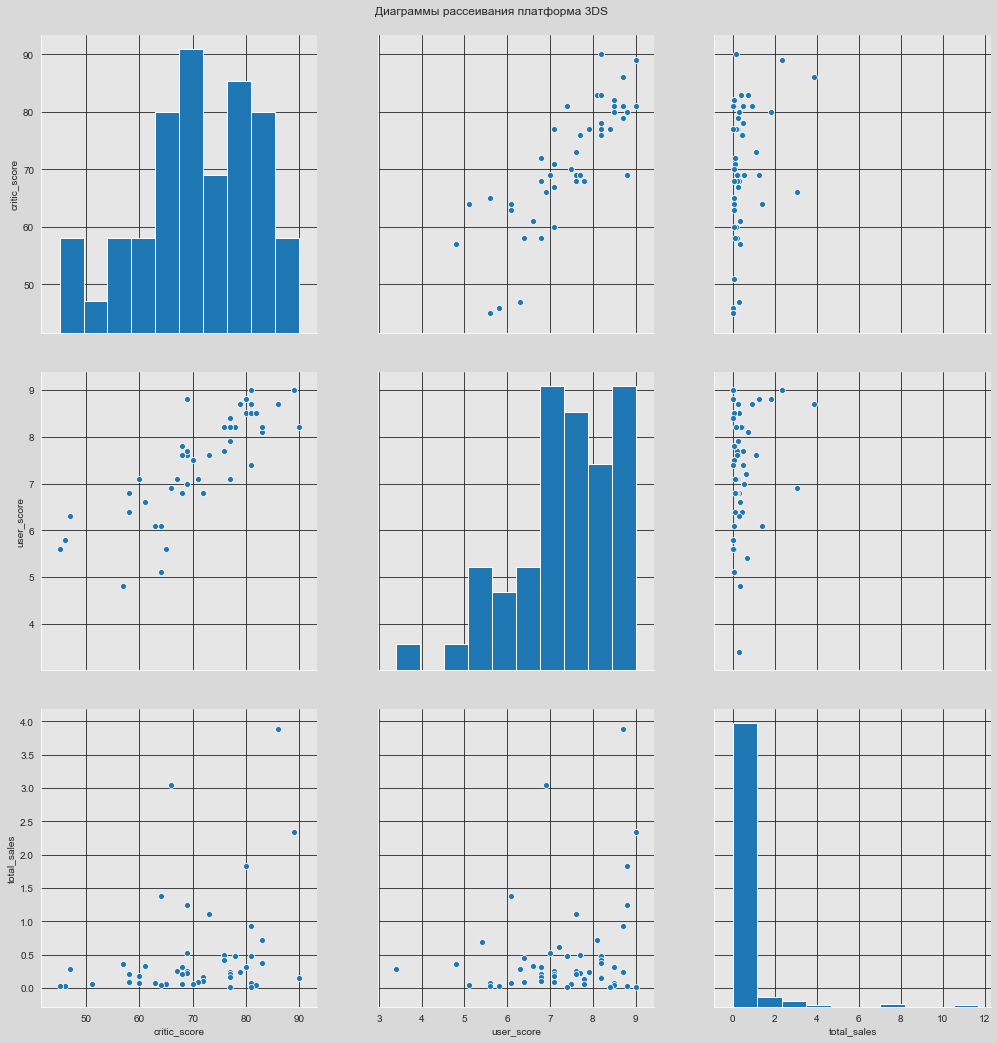

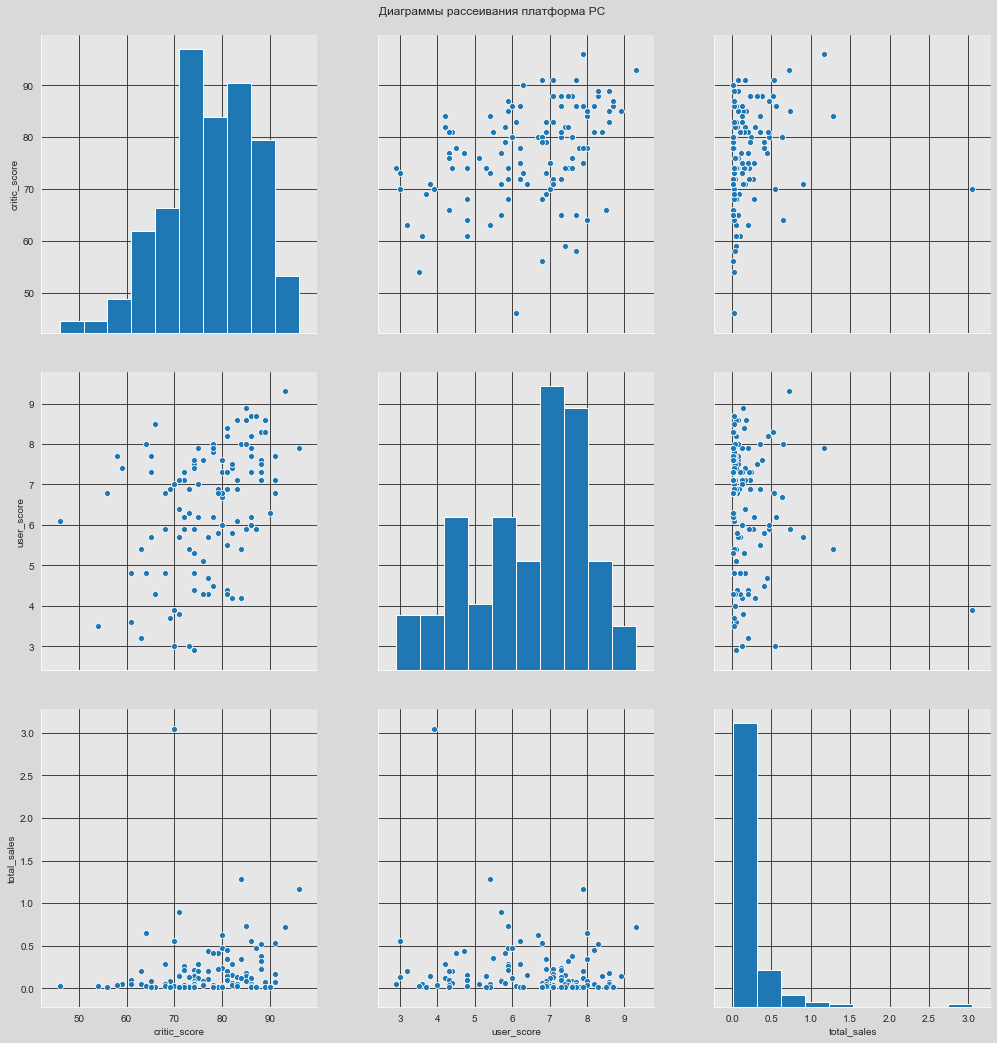

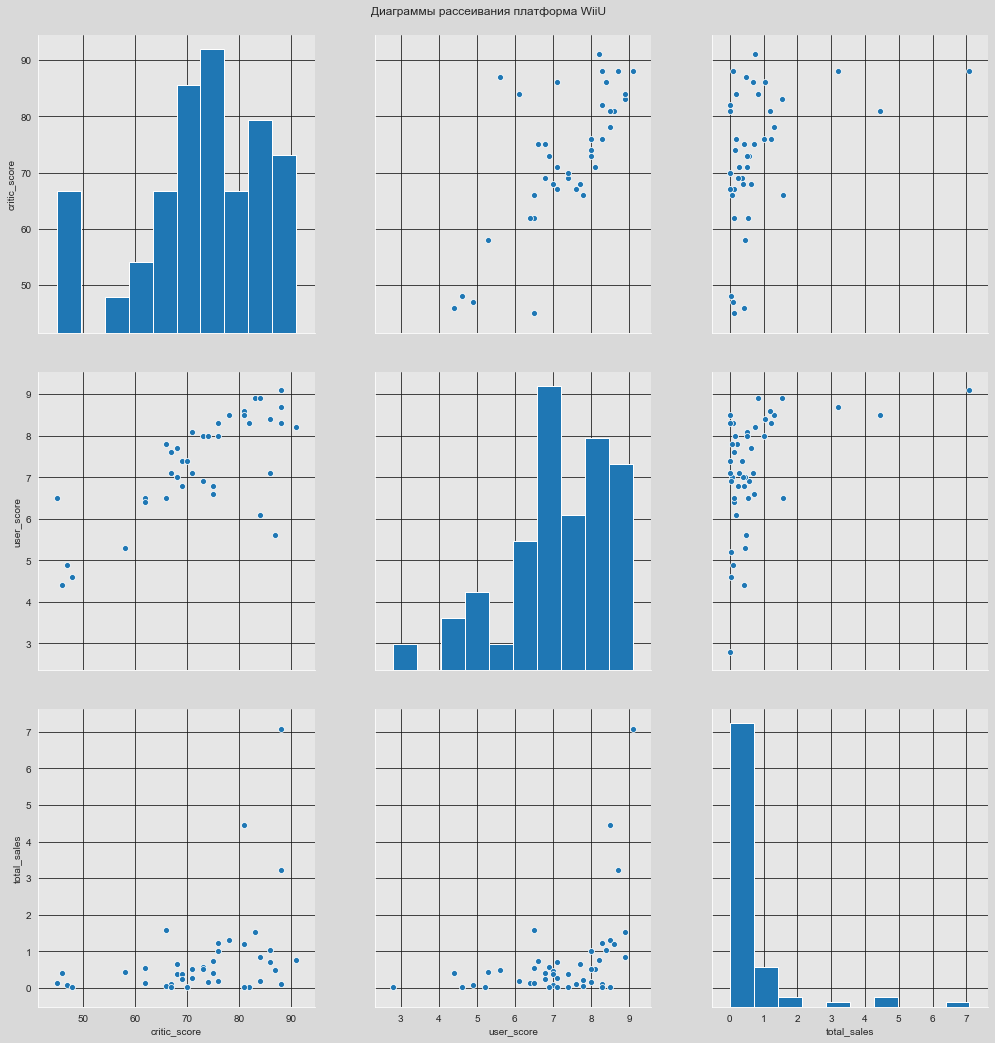

In [37]:
# строим корреляцию и графики рассеивания между общими продажами и отзывами критиков и пользователей по
# остальным платформам из ТОП, кроме рассмотренной выше
for platform in top_platform:
    if platform != platform_first: # проверяем, чтобы не ранее рассмотренная платформа была
        print(f'Таблица корреляции отзывов и продаж по платформе {platform}')
# строим таблицу корреляции по отзывам и доходам
        display(df.query('platform == @platform')[['critic_score', 'user_score', 'total_sales']].corr())
# графики рассеивания между собой по доходам и отзывам
        g= sns.pairplot(df.query('platform == @platform')[['critic_score', 'user_score', 'total_sales']])
# размер графика
        g.fig.set_size_inches(15,15)
# название графика
        g.fig.suptitle(f'Диаграммы рассеивания платформа {platform}', y=1); 

По остальным топ платформам картина достаточно схожа с платформой `PS4`. Нет никакой практически корреляции или небольшая между продажами и отзывами пользователей, исключение платформа `WiiU`, где отзывы пользователей средне коррелируют с продажами и есть небольшая корреляция по критикам и доходам.
Платформа `WiiU` и `3DS` выделяются по лучшим оценкам пользователей. Также эти платформы выделяются очень хитовыми играми.  

### Общее распределение игр по жанрам. Прибыльные жанры. Выделяются ли жанры с высокими и низкими продажами.

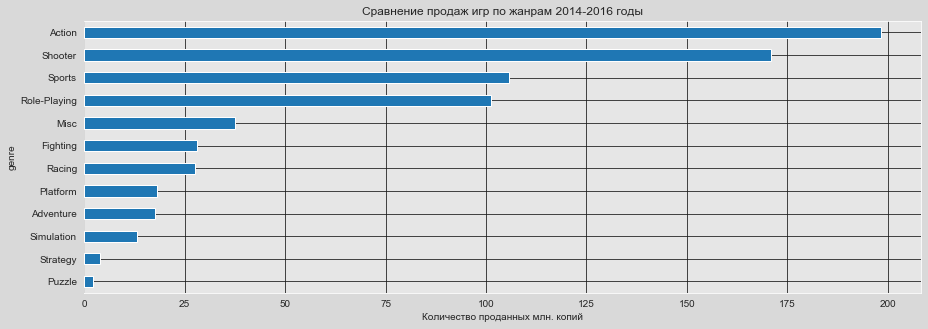

In [38]:
# строим столбчатый график по жанрам игр, отсортированным по проданным копиям в млн.за 2008-2016 годы
(df.pivot_table(index='genre', values='total_sales', aggfunc='sum').
     sort_values(by='total_sales')).plot(kind='barh', figsize=(15,5), legend=False)
plt.xlabel("Количество проданных млн. копий")
plt.title('Сравнение продаж игр по жанрам 2014-2016 годы');

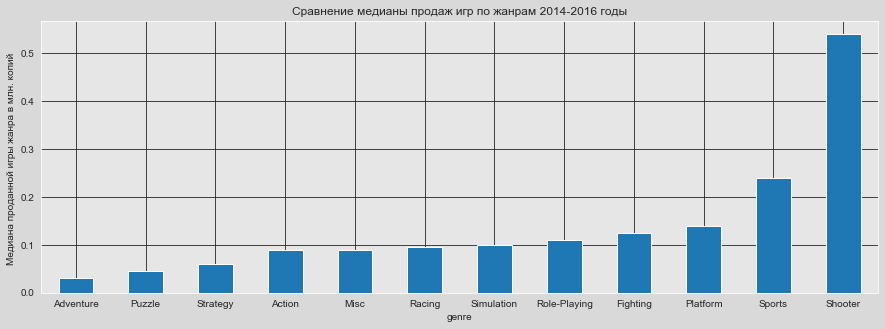

In [39]:
# столбчатый график медианного значения проданных игр в зависимости от жанра
(df.pivot_table(index='genre', values='total_sales', aggfunc='median').
     sort_values(by='total_sales')).plot(kind='bar', figsize=(15,5), legend=False)
plt.ylabel("Медиана проданной игры жанра в млн. копий ")
plt.xticks(rotation = 0)
plt.title('Сравнение медианы продаж игр по жанрам 2014-2016 годы');

По графикам можем видеть, что самое большое число проданных игр в жанре `Shooter` и `Action` с большим отрывом от остальных. По медианному значению продаж одной игры жанр `Action` внизу, это говорит о том, что это игры, популярные у разработчиков, но по прибыльности одной ниже среднего. А вот `Shooter`  явный лидер и по продажам в среднем одной игры. Это самый выгодный жанр для продаж.  
Жанры `Puzzle`, `Strategy` и `Adventure` в обоих типах графиков в самом низу и явные аутсайдеры.

## Портрет пользователя каждого региона (NA, EU, JP)

### Самые популярные платформы (топ-5). Различия в долях продаж.

In [40]:
# список из наименований столбцов продаж по каждому региону
regions = ['na_sales', 'eu_sales', 'jp_sales']

In [41]:
# функция, берет top-n по указанному региону и показывает доли относительно продаж
def region_top_platform_pie(df, region, ax, platform='platform', top_n=5):
# делаем выборку по каждой платформе по сумме дохода в регионе, сортируем по убыванию
    top_platform_region = (df.pivot_table(index=platform, values=region, aggfunc='sum').
     sort_values(by=region, ascending=False).reset_index())
# все платформы, которые не в top-n, мы обозначаем как 'other'
    top_platform_region.loc[top_n:,platform] = 'other'
    explode = [0.02 for i in range(top_n+1)]
    (top_platform_region.groupby(platform).agg({region : 'sum'}). 
     # суммируем в том числе прочие регионы, чтобы получить одно значение
                  plot(kind='pie', # график долевой
                  y=region, # по регионам
                  autopct='%1.2f%%', # указываем формат вывода значений на графике
                  label='', # убираем метки
                  explode=explode, # отделяем доли на графике
                  startangle=180, # поворачиваем на 180 градусов
                  ax=ax)) # привязываем `ax` к графику
# указываем название графика (регион) по которому рисует доли продажи
    ax.title.set_text(f'{region}')          

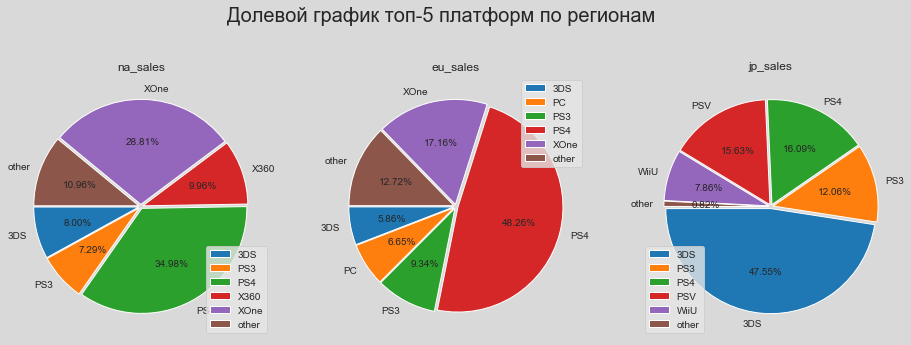

In [42]:
# создаем поле из колонок для наших графиков
fig, ax = plt.subplots(ncols=3, figsize=(16, 8))
fig.suptitle('Долевой график топ-5 платформ по регионам', # название всех графиков
             y = 0.85, # по вертикали положение названия
             fontsize = 20) # размер шрифта
# проходим в цикле по каждому региону функцию, рисующую долевой график для каждого региона 
for index, region in enumerate(regions):
    region_top_platform_pie(df,region, ax[index])
    # привязываем параметр ax к каждому графику для расположения 
    # и возможности указать title к привязке к графику

>* Если смотреть на долевые графики, мы видим, что в Северной Америке PS4 и XOne захватили 3/4 рынка, 
остальные платформы на имеет совсем небольшую аудиторию.   
>* В Европе явный лидер PS4 занявший половину рынка, далее платформа XOne, остальные платформы также отстают, как и в Северной Америке.  
>* В Японии же, пальму держит 3DS, занявший почти половину продаж, треть рынка забирает себе платформа Playstation 4 и 3 поколения, 16% у PSV, остальные непопулярны. В целом доля остальных платформ в Японии, кроме топ-5 менее 1%. Все платформы у японцев местные  - они приверженцы своего. 

### Самые популярные жанры (топ-5). Разница пояснение.

Применим ранее сделанную функцию для создания долевого графика для топ платформ, также и для топ жанров

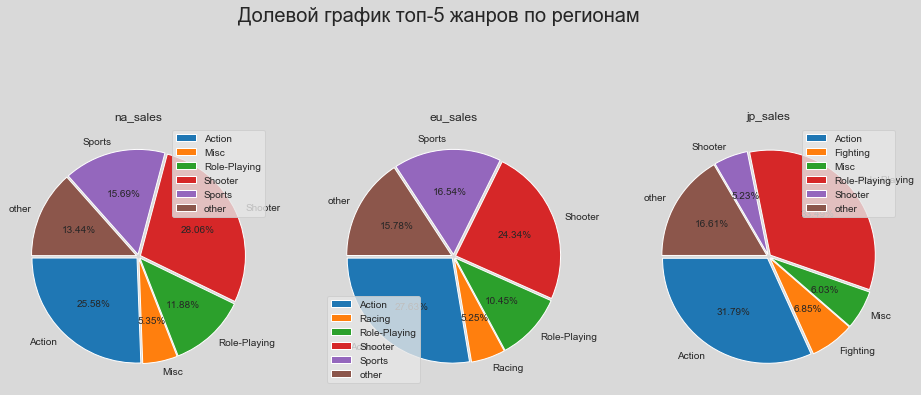

In [43]:
# создаем поле из колонок для наших графиков
fig, ax = plt.subplots(ncols=3, figsize=(16, 10))
fig.suptitle('Долевой график топ-5 жанров по регионам', # название всех графиков
             y = 0.85, # по вертикали положение названия
             fontsize = 20) # размер шрифта
# проходим в цикле по каждому региону функцию, рисующую долевой график для каждого региона 
for index, region in enumerate(regions):
    region_top_platform_pie(df,region, ax[index], platform='genre')
    # указываем в параметре платформа, по которому происходит
    # разбивка колонку `genre`, чтобы посмотреть разбивку по жанрам

>Касаемо жанров, мы видим, что в Северной Америке и Европе картина практически идентична - лидерами являются жанры `Shooter` и `Action`, за ним `Sports`, после `Role-Playing`. Это говорит, что в Европе и Америке любят больше динамичные игры.  
>В Японии же явные лидеры это `Action` и `Role-Playing` с 2/3 рынка. - Остальные отстают.

### Влияние рейтинга ESRB на продажи в отдельном регионе.

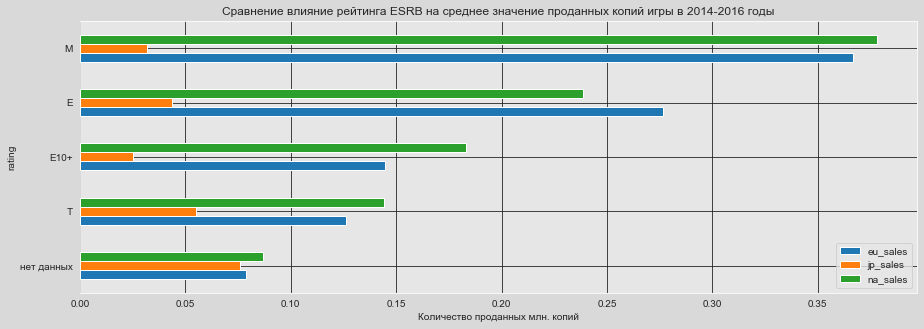

In [44]:
# строим столбчатый график по рейтингу ESRB игр по основным регионам 2008-2016 годы
(df.pivot_table(index='rating', values=regions, aggfunc='mean'). # сводная таблица по рейтинга по среднему 
                                                                 # продажи игры в регионе
     sort_values(by='na_sales'). # сортирируем по одному из регионов продаж (сомому большому)
     plot(kind='barh', figsize=(15,5))) # строим столбчатую диаграмму
plt.xlabel("Количество проданных млн. копий")
plt.title('Сравнение влияние рейтинга ESRB на среднее значение проданных копий игры в 2014-2016 годы');

По Японии видим, что в среднем рейтинг ESRB `T` более положительно связаны с продажами игр, чем остальные рейтинги. Но самое большее влияние имеют игры без данных о рейтинге, так как это скорее всего связано с тем, что рейтинг ESRB больше предназначен для рецензирования игр Северной Америки, и игры без данных это игры местные свои японские игры или корейские со своими рейтингами.    
Если сравнивать по рейтингам в Америке и Европе, то картина в Северной Америке и Европе очень похожи - самые доходные игры с рейтингом `M` (для взрослых), далее `E`, `E10+`.   

## Проверка гипотизы

### Гипотиза средние пользовательские рейтинги платформ XOne и PC одинаковые.

**Сформулируем нулевую гипотизу.**   
**Ho** ---> *средние пользовательские рейтинги платформ Xbox One и PC одинаковые.*  
**H1** ---> *средние пользовательские рейтинги платформ Xbox One и PC разные.*  
Зададим alpha = 0.05  
Для проверки гипотизы выберем критерий равенства средних двух генеральных совокупностей по взятым из них выборок. 

In [45]:
# задаем уровень значимости
alpha = 0.05

In [46]:
# фильтрую выборки по каждой из платформ по пользовательским рейтингам
xone_test = df.query('~user_score.isna() & platform == "XOne"')['user_score']
x_pc_test = df.query('~user_score.isna() & platform == "PC"')['user_score']

In [47]:
# проверим дисперсии двух выборок на гомогенность
stat_one_pc_test, p_one_pc_test = st.levene(xone_test, x_pc_test)

if p_one_pc_test < alpha:
    print('Дисперсии выборок различны')
else:
    print('Дисперсии выборок гомогенны')

Дисперсии выборок различны


In [48]:
# проверяем гипотезу о равенстве двух средних equal_var=False, так как дисперсии различаются
results_xone_pc = st.ttest_ind(xone_test, x_pc_test, equal_var=False)

# если p-value results_city окажется меньше установленного alpha - отвергнем гипотезу
print('p-значение:', results_xone_pc.pvalue)

if results_xone_pc.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Значения средних рейтингов: ')
display(df.query('platform == "XOne" | platform == "PC"').
        groupby('platform').agg({'user_score': 'mean'}).round(2).reset_index())

p-значение: 0.16717751306159076
Не получилось отвергнуть нулевую гипотезу
Значения средних рейтингов: 


,platform,user_score
0,PC,6.45
1,XOne,6.68


Мы не отвергаем нулевую гипотизу.  
**Средние пользовательские рейтинги платформ Xbox One и PC одинаковые**

### Гипотиза средние пользовательские рейтинги жанров *Action* и *Sports* разные.

**Сформулируем нулевую гипотизу.**   
**Ho** ---> *средние пользовательские рейтинги жанров `Action` и `Sports` одинаковые.*  
**H1** ---> *средние пользовательские рейтинги жанров `Action` и `Sports` разные.*  
Выбираем формулировку Ho, как равенство рейтингов, а альтернативная, что рейтинги разные.   
Зададим alpha = 0.05  
Для проверки гипотизы выберем критерий равенства средних двух генеральных совокупностей по взятым из них выборок.  

In [49]:
# фильтрую выборки по каждой из игр по пользовательским рейтингам
games_action_test = df.query('~user_score.isna() & genre == "Action"')['user_score']
games_sports_test = df.query('~user_score.isna() & genre == "Sports"')['user_score']

In [50]:
# проверим дисперсии двух выборок на гомогенность
stat_games_test, p_games_test = st.levene(games_action_test, games_sports_test)

if p_games_test < alpha:
    print('Дисперсии выборок различны')
else:
    print('Дисперсии выборок гомогенны')

Дисперсии выборок различны


In [51]:
# проверяем гипотезу о равенстве двух средних 
# equal_var=True устанавливливаем, так как дисперсии выборок гомогенны
results_action_sports = st.ttest_ind(games_action_test, games_sports_test)

# если p-value results_city окажется меньше установленного alpha - отвергнем гипотезу
print('p-значение:', results_action_sports.pvalue)

if results_action_sports.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
print('Значения средних рейтингов: ')
display(df.query('genre == "Action" | genre == "Sports"').
        groupby('genre').agg({'user_score': 'mean'}).round(2).reset_index())

p-значение: 8.510658745378095e-17
Отвергаем нулевую гипотезу
Значения средних рейтингов: 


,genre,user_score
0,Action,6.88
1,Sports,5.61


Мы отвергаем нулевую гипотизу.  
**Средние пользовательские рейтинги жанров `Action` и `Sports` разные**

## Общий вывод

**Мы видели по графикам потенциально прибыльных платформ, что *PS4*, *XOne* - единственные, которые показывали рост продаж последние годы. Это платформы - следующее поколение платформ *PS3* и *X360*. А самые прибыльные игры в плане стабильности в среднем по продажам на платформе *WiiU*, правда за хитами надо обращаться к *XOne*.
При выборе потенциально прибыльных игр, я бы обращал больше внимание на отзывы критиков, так как есть средняя илинебольшая взаимосвязь между продажами и рейтингами критиков, а вот пользовательские рейтинги не обнаружили линейной корреляции с продажами.  
Самое большое число проданных игр в жанре *Shooter* и *Action* и с большим отрывом от остальных. По медианному значению продаж одной игры *Shooter* полный лидер, это самые прибыльные игры.    
В рекламу жанров *Puzzle*, *Strategy* и *Adventure* стоит направлять минимальные вложения, так как это явные аутсайдеры по продажам.    
По регионам:**
- **в Северной Америке, впрочем, как и в Европе популярны жанры *Shooter* и *Action*, за ним *Sports*, после *Role-Plying*. По платформам самые популярные *PS4* и *XOne*, поэтому ставку надо делать на них. Рейтинг ESRP взаимосвязан с доходностью игры в Северной Америке и Европе очень похожи - самые доходные игры с рейтингом M (для взрослых), далее E, E10+.** 
  

- **в Европе по платформам и по жанрам ситуация схожа с Америкой, только можно выделить большую привязанность пользователей к *PS4*, чем *XOne*. В остальном всё очень схоже.**  
  

- **в Японии же пальма первенства явно за своими играми и платформами. По жанрам явный лидер это Action, с 43% рынка, четверть продаж у *Role-Playing*. По платформам пальму держит *3DS*, занявший 44% рынка продаж, треть рынка забирает себе платформа Playstation, 16% у PSV, остальные непопулярны.      По рейтингу ESRP наиболее популярны игры без рейтинга, своего местного производства.**